In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [ ]:
#Data stuff happens here
time_res = 2000
batch_size = 100 #19 batches
t_fine = np.linspace(0,76,time_res)

url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

raw_years = df.index.to_numpy()  # [1845, ..., 1921]
shifted_years = raw_years - raw_years[0]  # [0, ..., 76]

hares = df['Hare']
lynxes = df['Lynx']

hares_interp = interp1d(shifted_years, hares, kind='cubic')
lynxes_interp = interp1d(shifted_years, lynxes, kind='cubic')

hares_fine = hares_interp(t_fine)
lynxes_fine = lynxes_interp(t_fine)


data = np.array([hares_fine, lynxes_fine]).T
data_orig = data.copy()
# mu,sigma = data.mean(axis=0,keepdims=True),data.std(axis=0,keepdims=True)
# mu,sigma = torch.tensor(mu,dtype=torch.float32),torch.tensor(sigma,dtype=torch.float32)
# data_norm = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
# data = data_norm
data_test = data[:batch_size]
data = data[batch_size:]

t_fine_orig = t_fine.copy()

# t_fine = np.linspace(0,1.0,time_res)
t_fine_test = t_fine[:batch_size]
t_fine = t_fine[batch_size:]

print(data.shape)
print(t_fine.shape)
print(len(data))

/tmp/ipython-input-3-1866395998.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)


(1900, 2)
(1900,)
1900


In [ ]:
# Batching

num_batches = len(data) // batch_size
batched_data = data.reshape(num_batches, batch_size, 2)
batched_data_test = data_test.reshape(-1, batch_size, 2)

t_batches = t_fine.reshape(num_batches, batch_size)
t_batches_test = t_fine_test.reshape(-1, batch_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tested this UDE framework even on much shallower networks and with varying batch sizes only to get poor predicted dynamics. They flatten out and do not oscillate. Increasing lambda causes spectral loss to cause parameter blow up and solver underflow

In [ ]:
# ...existing code...

class FuncNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_func1 = nn.Sequential(
            nn.Linear(2, 32),
            nn.SiLU(),
            nn.Linear(32, 64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Linear(32, 1)
        )
        self.net_func2 = nn.Sequential(
            nn.Linear(2 , 32),
            nn.SiLU(),
            nn.Linear(32, 64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        f1 = self.net_func1(x)
        f2 = self.net_func2(x)
        return f1, f2

class LVParamLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_a = nn.Sequential(
            nn.Linear(2*batch_size, 64),
            nn.SiLU(),
            nn.Linear(64,128),
            nn.SiLU(),
            nn.Linear(128,128),
            nn.SiLU(),
            nn.Linear(128,64),
            nn.SiLU(),
            nn.Linear(64,8),
            nn.Tanh(),
            nn.Linear(8, 1)
        )
        self.func_net = FuncNet(batch_size)
        self.net_g = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.SiLU(),
            nn.Linear(64,128),
            nn.SiLU(),
            nn.Linear(128,128),
            nn.SiLU(),
            nn.Linear(128,64),
            nn.SiLU(),
            nn.Linear(64,8),
            nn.Tanh(),
            nn.Linear(8, 1)
        )
        self.net_k = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.SiLU(),
            nn.Linear(64,128),
            nn.SiLU(),
            nn.Linear(128,128),
            nn.SiLU(),
            nn.Linear(128,64),
            nn.SiLU(),
            nn.Linear(64,8),
            nn.SiLU(),
            nn.Linear(8, 1)
        )
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.sigm = lambda z: nn.functional.softplus(z)

    def forward(self, x):
        x = torch.flatten(torch.tensor(x, dtype=torch.float32))
        a = self.net_a(x)
        f1, f2 = self.func_net(x)
        g = self.net_g(x)
        k = self.net_k(x)
        return self.sigm(a), f1, self.sigm(g), f2, self.sigm(k)

# ...existing code...

In [ ]:
paramlearner = LVParamLearner()
paramlearner.to(device)
FuncNet = FuncNet()
FuncNet.to(device)
optimizer = torch.optim.Adam(paramlearner.parameters(), lr=2e-5)
optimizer_func = torch.optim.Adam(FuncNet.parameters(), lr=2e-5)

In [ ]:
lamb = 0.2

def spectrum_loss(y_true, y_pred):
    """
    Compute MSE in frequency space (real-valued FFT comparison).
    y_true and y_pred shape: [T] or [B, T]
    """
    # Subtract mean to remove DC component
    y_true = y_true - y_true.mean(dim=-1, keepdim=True)
    y_pred = y_pred - y_pred.mean(dim=-1, keepdim=True)

    # Compute FFT magnitudes (real-valued)
    f_true = torch.fft.rfft(y_true, dim=-1)
    f_pred = torch.fft.rfft(y_pred, dim=-1)

    # Compute magnitude spectrum
    mag_true = torch.abs(f_true)
    mag_pred = torch.abs(f_pred)

    return torch.mean((mag_true - mag_pred) ** 2)

In [ ]:
def make_logistic_lv_dynamics(alpha, gamma, K):
    def dynamics(t, y):
        f1,f2 = FuncNet(y)
        f1 = f1.squeeze(-1)
        f2 = f2.squeeze(-1)
        x, y_pred = y[0], y[1]

        dxdt = alpha * x * (1 - x / K) + f1
        dydt = f2 - gamma * y_pred

        return torch.stack([dxdt, dydt])
    return dynamics



In [ ]:

t_fine = torch.tensor(t_fine,device=device)
pred = 0
for epoch in range(500):
  for data_batch,time_batch in zip(batched_data,t_batches):
    optimizer.zero_grad()
    data_batch = torch.tensor(data_batch,device=device)
    y0 = data_batch[0]
    y0 = torch.tensor(y0)
    time_batch = torch.tensor(time_batch)
    params = paramlearner(data_batch)

    alp,gam,k = params
    alp,gam,k = alp.squeeze(),gam.squeeze(),k.squeeze()
    
    dynamics = make_logistic_lv_dynamics(alp,gam,k)

    pred = odeint(dynamics,y0,time_batch,method='dopri5')

    target = torch.tensor(data_batch,device=device)
    loss = torch.mean(((pred - target)**2)) +  lamb * spectrum_loss(pred,target)


    if torch.isnan(loss):
      print("Loss became NaN — printing parameters")
      print(alp,gam,k)
      break
    loss.backward()
    optimizer.step()

  print(f"EPoch: {epoch} and Loss:{loss}")



/tmp/ipython-input-10-4034956128.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(y0)
/tmp/ipython-input-6-3919750682.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.flatten(torch.tensor(x,dtype=torch.float32))


tensor(0.8652, grad_fn=<SqueezeBackward0>) tensor(0.2167, grad_fn=<SqueezeBackward0>) tensor(0.7024, grad_fn=<SqueezeBackward0>) tensor(2.8067, grad_fn=<SqueezeBackward0>) tensor(0.7983, grad_fn=<SqueezeBackward0>)


/tmp/ipython-input-10-4034956128.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data_batch,device=device)


Streaming output truncated to the last 5000 lines.
tensor(1.1106, grad_fn=<SqueezeBackward0>) tensor(11.4717, grad_fn=<SqueezeBackward0>) tensor(1.2900, grad_fn=<SqueezeBackward0>) tensor(6.3198, grad_fn=<SqueezeBackward0>) tensor(74.5620, grad_fn=<SqueezeBackward0>)
tensor(1.3257, grad_fn=<SqueezeBackward0>) tensor(-2.4160, grad_fn=<SqueezeBackward0>) tensor(0.3406, grad_fn=<SqueezeBackward0>) tensor(16.2552, grad_fn=<SqueezeBackward0>) tensor(81.2653, grad_fn=<SqueezeBackward0>)
tensor(0.3822, grad_fn=<SqueezeBackward0>) tensor(-12.9967, grad_fn=<SqueezeBackward0>) tensor(0.6492, grad_fn=<SqueezeBackward0>) tensor(7.3185, grad_fn=<SqueezeBackward0>) tensor(30.9047, grad_fn=<SqueezeBackward0>)
tensor(0.3120, grad_fn=<SqueezeBackward0>) tensor(20.2206, grad_fn=<SqueezeBackward0>) tensor(0.4115, grad_fn=<SqueezeBackward0>) tensor(7.7199, grad_fn=<SqueezeBackward0>) tensor(131.4139, grad_fn=<SqueezeBackward0>)
tensor(0.3113, grad_fn=<SqueezeBackward0>) tensor(-25.3879, grad_fn=<SqueezeBa

In [ ]:
alpha,gamma,k = paramlearner(batched_data[0])
print(alpha,gamma,k)

alpha,gamma,k = alpha.squeeze(),gamma.squeeze(),k.squeeze()
y0 = torch.tensor(batched_data[0][0],dtype=torch.float32)
print(y0)
pred = odeint(make_logistic_lv_dynamics(alpha,gamma,k),y0,t_fine)
# pred = pred * sigma + mu


tensor([1.4904], grad_fn=<SoftplusBackward0>) tensor([-1.1557], grad_fn=<ViewBackward0>) tensor([1.2304], grad_fn=<SoftplusBackward0>) tensor([5.4832], grad_fn=<ViewBackward0>) tensor([82.4223], grad_fn=<SoftplusBackward0>)
tensor([22.9507, 24.8432])


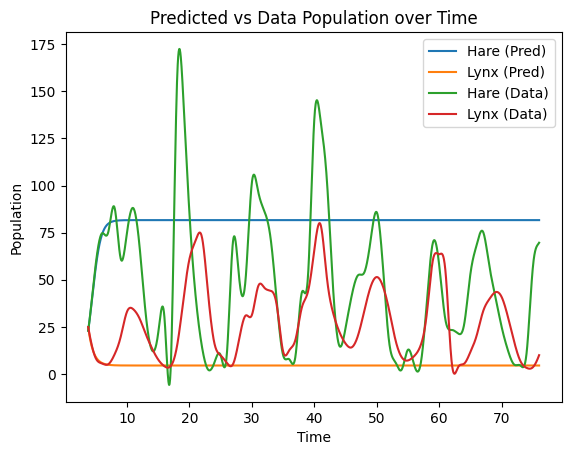

In [ ]:
# prompt: Simply plot pred against data

import matplotlib.pyplot as plt
plt.plot(t_fine.cpu().detach().numpy(), pred.cpu().detach().numpy()[:, 0], label='Hare (Pred)')
plt.plot(t_fine.cpu().detach().numpy(), pred.cpu().detach().numpy()[:, 1], label='Lynx (Pred)')
plt.plot(t_fine_orig[100:], data_orig[100:, 0], label='Hare (Data)')
plt.plot(t_fine_orig[100:], data_orig[100:, 1], label='Lynx (Data)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predicted vs Data Population over Time')
plt.legend()
plt.show()